# Training run visualization

Choisissez un dossier de run (ex: `runs/2025-12-19_181407`) pour inspecter la config, les courbes de perte et la matrice de confusion. Les résultats seront sauvegardés dans `results/<config_name ou run_dir>/`.

Run dir: runs\2025-12-19_143432
Config name: ﻿all_in_one
Config YAML keys: ['seed', 'data', 'augmentation', 'model', 'optim', 'loss', 'scheduler', 'train', 'checkpoint', 'output']
Résultats enregistrés dans: results\﻿all_in_one
Logs shape: (20, 3)
Summary: (absent)


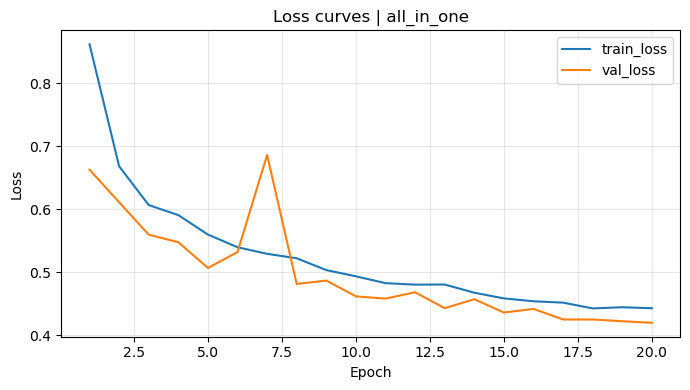

Courbes de perte sauvegardées: results\﻿all_in_one\loss_curves.png
Confusion loaded | shape=(9, 9) | acc=0.8273


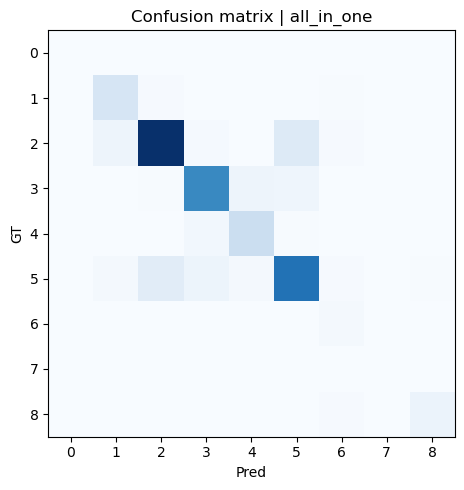

Matrice de confusion sauvegardée: results\﻿all_in_one\confusion_matrix.png
Résumé texte sauvegardé: results\﻿all_in_one\summary.txt


In [ ]:
from pathlib import Path
import json
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

# --- Paramétrage : choisissez un dossier de run ---
runs_dir = Path("runs")
run_dir = runs_dir / "2025-12-19_143432"  # <-- à modifier si besoin

# --- Chargement config et nom de config ---
cfg_txt_path = run_dir / "config.txt"
cfg_yaml_path = run_dir / "config.yaml"
config_name = None
if cfg_txt_path.exists():
    with open(cfg_txt_path, "r", encoding="utf-8") as f:
        lines = f.read().splitlines()
    if lines:
        config_name = lines[0].strip()
cfg = None
if cfg_yaml_path.exists():
    with open(cfg_yaml_path, "r", encoding="utf-8") as f:
        cfg = yaml.safe_load(f)

run_label = config_name or run_dir.name
print(f"Run dir: {run_dir}")
print(f"Config name: {config_name}")
print("Config YAML keys:", list(cfg.keys()) if cfg else "(config.yaml non trouvé)")

# --- Dossier de résultats ---
results_root = Path("results")
results_dir = results_root / run_label
results_dir.mkdir(parents=True, exist_ok=True)
print(f"Résultats enregistrés dans: {results_dir}")

# --- Logs d'entraînement ---
logs_path = run_dir / "logs.csv"
logs_df = pd.read_csv(logs_path) if logs_path.exists() else None
print("Logs shape:", logs_df.shape if logs_df is not None else "(absent)")

# --- Metrics summary (dossier metrics) ---
metrics_dir = run_dir / "metrics"
summary = None
per_class = None
conf_path = None
if metrics_dir.exists():
    summary_path = metrics_dir / "summary.json"
    per_class_path = metrics_dir / "per_class.json"
    conf_path = metrics_dir / "confusion_best.json"
    if summary_path.exists():
        with open(summary_path, "r", encoding="utf-8") as f:
            summary = json.load(f)
    if per_class_path.exists():
        with open(per_class_path, "r", encoding="utf-8") as f:
            per_class = json.load(f)
print("Summary:", summary if summary else "(absent)")

# --- Courbes de perte ---
loss_fig_path = results_dir / "loss_curves.png"
if logs_df is not None:
    plt.figure(figsize=(7, 4))
    plt.plot(logs_df["epoch"], logs_df["train_loss"], label="train_loss")
    if "val_loss" in logs_df.columns:
        plt.plot(logs_df["epoch"], logs_df["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss curves | {run_label}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(loss_fig_path, dpi=150)
    plt.show()
    print(f"Courbes de perte sauvegardées: {loss_fig_path}")

# --- Matrice de confusion ---
if conf_path is None:
    conf_path = run_dir / "val_confusion_best.json"
conf_fig_path = results_dir / "confusion_matrix.png"
acc = None
if conf_path.exists():
    with open(conf_path, "r", encoding="utf-8") as f:
        conf = np.array(json.load(f), dtype=float)
    num_classes = conf.shape[0]
    class_labels = [f"c{i}" for i in range(num_classes)]
    acc = float(np.trace(conf) / max(conf.sum(), 1.0))
    
    print(f"Confusion loaded | shape={conf.shape} | acc={acc:.4f}")

    plt.figure(figsize=(6, 5))
    if _HAS_SNS:
        sns.heatmap(conf, annot=False, fmt=".0f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    else:
        plt.imshow(conf, cmap="Blues")
    plt.title(f"Confusion matrix | {run_label}")
    plt.xlabel("Pred")
    plt.ylabel("GT")
    plt.tight_layout()
    plt.savefig(conf_fig_path, dpi=150)
    plt.show()
    print(f"Matrice de confusion sauvegardée: {conf_fig_path}")
else:
    print("Confusion non trouvée")

# --- Sauvegarde d'un fichier texte récapitulatif ---
txt_path = results_dir / "summary.txt"
lines = []
lines.append(f"run_dir: {run_dir}")
lines.append(f"config_name: {config_name}")
if summary:
    lines.append(f"monitor: {summary.get('monitor')}")
    lines.append(f"best_metric: {summary.get('best_metric')}")
    lines.append(f"best_epoch: {summary.get('best_epoch')}")
if acc is not None:
    lines.append(f"accuracy: {acc:.6f}")
if per_class:
    mean = per_class.get("mean", {})
    lines.append(f"miou: {mean.get('miou')}")
    lines.append(f"precision: {mean.get('precision')}")
    lines.append(f"recall: {mean.get('recall')}")

with open(txt_path, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))
print(f"Résumé texte sauvegardé: {txt_path}")
